In [1]:
import argparse
from state import State
from data_loader import load_data
from agent import Agent
from attention import Attention
import torch.nn as nn
import torch
import numpy as np
from tqdm import tqdm
from evaluate import computeF1, evaluate
import math
import random

class ReactiveBaseline():
    def __init__(self, l):
        self.l = l
        self.b = 0.0
    def get_baseline_value(self):
        return self.b
    def update(self, target):
        self.b = (1-self.l)*self.b + self.l*target


GAMMA = 1
WORD_EMB_DIM = 94
NODE_EMB_DIM = 30
H_DIM = 64
T = 3
NUM_EPOCH = 1000
SOFT_REWARD_SCALE = 0.1
NUM_ROLL_OUT = 1
SHUFFLE = False

# device 
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# arguemnt parsing
# load dataset
node_embedding, rel_embedding, kg, train, test = load_data("countries", WORD_EMB_DIM, "ComplEX")


# projection from word embedding to node node embedding
word2node = nn.Linear(WORD_EMB_DIM, NODE_EMB_DIM, bias=False).to(device)

# mutihead self-attention
attention = Attention(4, NODE_EMB_DIM, H_DIM, math.sqrt(H_DIM)).to(device)

# list contains all params that need to optimize
model_param_list = list(word2node.parameters()) + list(attention.parameters())

# init agent
state = State((train[0][1],train[0][2]), kg, node_embedding, WORD_EMB_DIM, word2node, attention, rel_embedding, T, device) # init here to calculate the input size
input_dim = state.get_input_size()
num_rel = len(kg.rel_vocab)
num_entity = len(kg.en_vocab)
num_subgraph = len(state.subgraphs)
emb_dim = WORD_EMB_DIM + NODE_EMB_DIM
baseline = ReactiveBaseline(l = 0.02)
agent = Agent(input_dim, 32, emb_dim, 0, 2, num_entity, num_rel,num_subgraph, GAMMA, 0.00005, model_param_list, baseline, device)

# training loop
index_list = list(range(len(train)))
true_positive_question = []
for epoch in range(NUM_EPOCH):
    true_positive_question = []
    losses = []
    rewards = []
    correct = 0
    true_positive = 0
    f1 = []
    if SHUFFLE:
        random.shuffle(index_list)
    for n in tqdm(range(len(train))):
        # create state from the question
        i = index_list[n]
        for _ in range(NUM_ROLL_OUT):
            state = State((train[i][1],train[i][2]), kg, node_embedding, WORD_EMB_DIM, word2node, attention, rel_embedding, T, device)
            answers = kg.encode_answers(train[i][0])
            e0 = state.subgraphs[0][0]
            agent.policy.init_path(e0, state)

            # go for T step
            for step in range(T):
                action = agent.get_action(state)
                g, r, e = action
                if step < T-1:
                    agent.hard_reward(0)
                else:
                    nodes = state.get_last_nodes()
                    max_shortest_path = kg.max_shortest_path(nodes)
                    if e in answers and max_shortest_path == 0:
                        correct += 1
                        true_positive += 1
                        true_positive_question.append(i)
                        agent.hard_reward(10)
                    elif e in answers:
                        agent.hard_reward(1)
                        correct += 1
                    else:
                        agent.hard_reward(0)
                        #answer_embedding = state.node_embedding[answer]
                        #e_embedding = state.node_embedding[e]
                        #agent.soft_reward(answer_embedding, e_embedding, SOFT_REWARD_SCALE, -max_shortest_path)
                state.update(action)
                #print("step: " + str(step) + ", take action: " + str(action) + "result_subgraphs:" + str(state.subgraphs))

            # update the policy net and record loss
            loss, reward, last_reward = agent.update_policy()
            losses.append(loss)
            rewards.append(reward)

    acc = correct/(NUM_ROLL_OUT*len(train))
    avg_loss = np.mean(losses)
    avg_reward = np.mean(rewards)
    print(true_positive_question)
    print("epoch: {}, loss: {}, reward: {}, true_positive: {}, acc: {}".format(epoch, avg_loss, avg_reward, true_positive/NUM_ROLL_OUT, acc))

    # evaluate on test set
    if (epoch)%5 == 0:
        evaluate(test, agent, kg, T, WORD_EMB_DIM, word2node, attention, rel_embedding, node_embedding, device, 15)

  0%|          | 0/145 [00:00<?, ?it/s]

[286, 335, 359]
epoch: 0, loss: -0.0852677291988777, reward: 0.4976958525345622, true_positive: 3.0, acc: 0.10368663594470046


  0%|          | 1/434 [00:00<01:01,  7.08it/s]

hit@1: 0.15862068965517243, hit@2: 0.2206896551724138, hit@3: 0.2827586206896552, hit@5: 0.3724137931034483, hit@10: 0.4827586206896552
avg out degree for pciked node 1 is 1.910344827586207
avg out degree for pciked node 2 is 1.910344827586207
avg out degree for pciked node 3 is 3.282758620689655


  0%|          | 0/434 [00:00<?, ?it/s]

[]
epoch: 1, loss: -0.20946532748811256, reward: 0.3456221198156682, true_positive: 0.0, acc: 0.1152073732718894


  0%|          | 0/434 [00:00<?, ?it/s]

[163]
epoch: 2, loss: -0.18498670615358836, reward: 0.44930875576036866, true_positive: 1.0, acc: 0.12903225806451613


  0%|          | 0/434 [00:00<?, ?it/s]

[]
epoch: 3, loss: -0.2420195677588063, reward: 0.38018433179723504, true_positive: 0.0, acc: 0.12672811059907835


  0%|          | 0/434 [00:00<?, ?it/s]

[227, 359]
epoch: 4, loss: -0.16480269018680818, reward: 0.532258064516129, true_positive: 2.0, acc: 0.1359447004608295


  0%|          | 0/145 [00:00<?, ?it/s]

[227, 359]
epoch: 5, loss: -0.36257030670681306, reward: 0.6359447004608295, true_positive: 2.0, acc: 0.17050691244239632


  0%|          | 0/434 [00:00<?, ?it/s]

hit@1: 0.13793103448275862, hit@2: 0.2482758620689655, hit@3: 0.31724137931034485, hit@5: 0.4413793103448276, hit@10: 0.5448275862068965
avg out degree for pciked node 1 is 1.282758620689655
avg out degree for pciked node 2 is 2.8689655172413793
avg out degree for pciked node 3 is 3.075862068965517


  0%|          | 0/434 [00:00<?, ?it/s]

[317]
epoch: 6, loss: -0.18996398714435403, reward: 0.5529953917050692, true_positive: 1.0, acc: 0.16359447004608296


  0%|          | 0/434 [00:00<?, ?it/s]

[339, 359]
epoch: 7, loss: -0.32913191528982283, reward: 0.6221198156682027, true_positive: 2.0, acc: 0.16589861751152074


  0%|          | 0/434 [00:00<?, ?it/s]

[227, 317, 339, 359]
epoch: 8, loss: -0.5458568562689121, reward: 0.8294930875576036, true_positive: 4.0, acc: 0.1935483870967742


  0%|          | 0/434 [00:00<?, ?it/s]

[227, 229, 317, 339, 359]
epoch: 9, loss: -0.47459852812631476, reward: 1.0023041474654377, true_positive: 5.0, acc: 0.2304147465437788


  0%|          | 0/145 [00:00<?, ?it/s]

[317, 339, 359]
epoch: 10, loss: -0.5043985052635113, reward: 0.9539170506912442, true_positive: 3.0, acc: 0.2557603686635945


  0%|          | 0/434 [00:00<?, ?it/s]

hit@1: 0.32413793103448274, hit@2: 0.35172413793103446, hit@3: 0.4068965517241379, hit@5: 0.46206896551724136, hit@10: 0.5517241379310345
avg out degree for pciked node 1 is 0.9724137931034482
avg out degree for pciked node 2 is 1.4896551724137932
avg out degree for pciked node 3 is 2.496551724137931


  0%|          | 0/434 [00:00<?, ?it/s]

[183, 227, 317, 339, 359, 422]
epoch: 11, loss: -0.4416961957939819, reward: 1.1751152073732718, true_positive: 6.0, acc: 0.2672811059907834


  0%|          | 0/434 [00:00<?, ?it/s]

[227, 317, 339, 359, 422]
epoch: 12, loss: -0.5096416863001785, reward: 1.1751152073732718, true_positive: 5.0, acc: 0.2880184331797235


  0%|          | 0/434 [00:00<?, ?it/s]

[183, 227, 317, 339, 359, 422]
epoch: 13, loss: -0.4886811124134062, reward: 1.2857142857142858, true_positive: 6.0, acc: 0.30414746543778803


  0%|          | 0/434 [00:00<?, ?it/s]

[227, 286, 317, 339, 359, 422]
epoch: 14, loss: -0.4181902539909765, reward: 1.3617511520737327, true_positive: 6.0, acc: 0.3294930875576037


  0%|          | 0/145 [00:00<?, ?it/s]

[183, 227, 286, 317, 339, 359, 422]
epoch: 15, loss: -0.5147263354221214, reward: 1.403225806451613, true_positive: 7.0, acc: 0.3225806451612903


  0%|          | 0/434 [00:00<?, ?it/s]

hit@1: 0.3103448275862069, hit@2: 0.3793103448275862, hit@3: 0.4206896551724138, hit@5: 0.47586206896551725, hit@10: 0.5793103448275863
avg out degree for pciked node 1 is 1.1724137931034482
avg out degree for pciked node 2 is 1.9379310344827587
avg out degree for pciked node 3 is 2.9448275862068964


  0%|          | 0/434 [00:00<?, ?it/s]

[227, 259, 286, 317, 339, 359, 422]
epoch: 16, loss: -0.4290718450646205, reward: 1.4654377880184333, true_positive: 7.0, acc: 0.3433179723502304


  0%|          | 0/434 [00:00<?, ?it/s]

[227, 259, 286, 317, 339, 359, 422]
epoch: 17, loss: -0.42318549104922465, reward: 1.423963133640553, true_positive: 7.0, acc: 0.3294930875576037


  0%|          | 0/434 [00:00<?, ?it/s]

[183, 227, 259, 286, 317, 339, 359, 422]
epoch: 18, loss: -0.3682063731458303, reward: 1.5345622119815667, true_positive: 8.0, acc: 0.3456221198156682


  0%|          | 0/434 [00:00<?, ?it/s]

[183, 227, 259, 286, 317, 339, 359, 422]
epoch: 19, loss: -0.3208111919154178, reward: 1.5483870967741935, true_positive: 8.0, acc: 0.35023041474654376


  0%|          | 0/145 [00:00<?, ?it/s]

[183, 227, 259, 286, 317, 339, 359, 422]
epoch: 20, loss: -0.3022885849425784, reward: 1.5622119815668203, true_positive: 8.0, acc: 0.3548387096774194


  0%|          | 0/434 [00:00<?, ?it/s]

hit@1: 0.3310344827586207, hit@2: 0.4, hit@3: 0.4413793103448276, hit@5: 0.47586206896551725, hit@10: 0.5862068965517241
avg out degree for pciked node 1 is 1.296551724137931
avg out degree for pciked node 2 is 2.0620689655172413
avg out degree for pciked node 3 is 2.682758620689655


  0%|          | 0/434 [00:00<?, ?it/s]

[183, 227, 259, 286, 317, 339, 359, 422]
epoch: 21, loss: -0.3045854981897459, reward: 1.5898617511520738, true_positive: 8.0, acc: 0.3640552995391705


  0%|          | 0/434 [00:00<?, ?it/s]

[183, 227, 259, 286, 317, 339, 359, 422]
epoch: 22, loss: -0.3132218324742626, reward: 1.6935483870967742, true_positive: 8.0, acc: 0.3986175115207373


  0%|          | 0/434 [00:00<?, ?it/s]

[183, 227, 286, 317, 339, 359, 422]
epoch: 23, loss: -0.32552092845359026, reward: 1.6036866359447004, true_positive: 7.0, acc: 0.38940092165898615


  0%|          | 0/434 [00:00<?, ?it/s]

[183, 259, 286, 317, 339, 359, 422]
epoch: 24, loss: -0.3203061040534457, reward: 1.5898617511520738, true_positive: 7.0, acc: 0.3847926267281106


  0%|          | 0/145 [00:00<?, ?it/s]

[183, 259, 286, 317, 359, 422]
epoch: 25, loss: -0.25812524798422043, reward: 1.5414746543778801, true_positive: 6.0, acc: 0.38940092165898615


  0%|          | 0/434 [00:00<?, ?it/s]

hit@1: 0.3586206896551724, hit@2: 0.4068965517241379, hit@3: 0.4413793103448276, hit@5: 0.4689655172413793, hit@10: 0.5448275862068965
avg out degree for pciked node 1 is 1.5793103448275863
avg out degree for pciked node 2 is 1.9586206896551723
avg out degree for pciked node 3 is 2.303448275862069


  0%|          | 0/434 [00:00<?, ?it/s]

[183, 229, 286, 317, 339, 359, 422]
epoch: 26, loss: -0.28816245739269375, reward: 1.6175115207373272, true_positive: 7.0, acc: 0.39400921658986177


  0%|          | 0/434 [00:00<?, ?it/s]

[183, 229, 259, 286, 317, 339, 359, 422]
epoch: 27, loss: -0.2534433163760873, reward: 1.7211981566820276, true_positive: 8.0, acc: 0.4078341013824885


  0%|          | 0/434 [00:00<?, ?it/s]

[183, 229, 259, 286, 317, 339, 359, 422]
epoch: 28, loss: -0.29306129473369047, reward: 1.6797235023041475, true_positive: 8.0, acc: 0.39400921658986177


  0%|          | 0/434 [00:00<?, ?it/s]

[183, 229, 259, 286, 317, 339, 359, 422]
epoch: 29, loss: -0.20720394677403692, reward: 1.707373271889401, true_positive: 8.0, acc: 0.4032258064516129


  0%|          | 0/145 [00:00<?, ?it/s]

[183, 229, 259, 286, 317, 339, 359, 422]
epoch: 30, loss: -0.2085853809030076, reward: 1.7488479262672811, true_positive: 8.0, acc: 0.41705069124423966


  0%|          | 0/434 [00:00<?, ?it/s]

hit@1: 0.3724137931034483, hit@2: 0.3931034482758621, hit@3: 0.42758620689655175, hit@5: 0.47586206896551725, hit@10: 0.5793103448275863
avg out degree for pciked node 1 is 1.4758620689655173
avg out degree for pciked node 2 is 2.510344827586207
avg out degree for pciked node 3 is 2.2758620689655173


  0%|          | 0/434 [00:00<?, ?it/s]

[183, 229, 259, 286, 317, 339, 359, 422]
epoch: 31, loss: -0.2071762140029082, reward: 1.7004608294930876, true_positive: 8.0, acc: 0.4009216589861751


  0%|          | 0/434 [00:00<?, ?it/s]

[183, 229, 259, 286, 317, 339, 359, 422]
epoch: 32, loss: -0.21906505251631778, reward: 1.6797235023041475, true_positive: 8.0, acc: 0.39400921658986177


  0%|          | 0/434 [00:00<?, ?it/s]

[183, 229, 286, 317, 339, 359, 422]
epoch: 33, loss: -0.2301907346001673, reward: 1.6451612903225807, true_positive: 7.0, acc: 0.4032258064516129


 70%|██████▉   | 302/434 [01:06<00:29,  4.45it/s]

KeyboardInterrupt: 

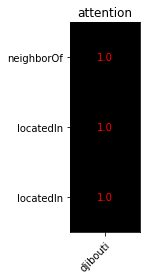

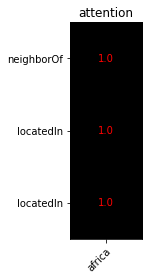

[['djibouti'], ['africa']]
1 locatedIn guinea


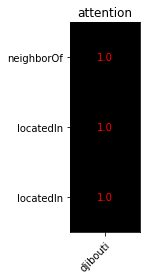

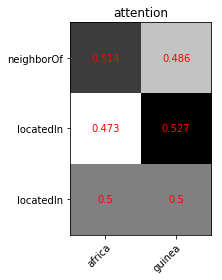

[['djibouti'], ['africa', 'guinea']]
1 locatedIn djibouti


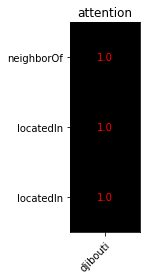

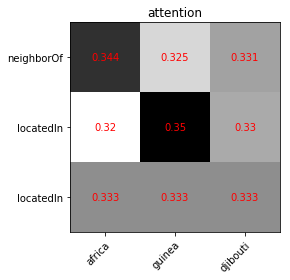

[['djibouti'], ['africa', 'guinea', 'djibouti']]
0 neighborOf eritrea
[['djibouti', 'eritrea'], ['africa', 'guinea', 'djibouti']]


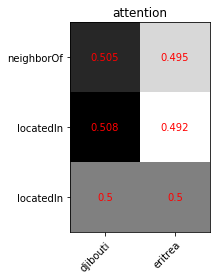

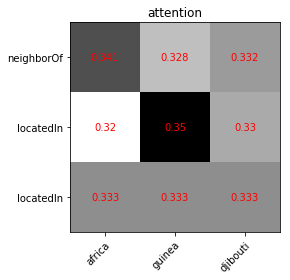

['ethiopia', 'somalia', 'eritrea']
predicted: djibouti


In [14]:
import torch
import torch.nn.functional as F
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

# select the question you want to visualize
question_number = 183

def find_ename(e):
    for e_name in state.graph.en_vocab:
        if state.graph.en_vocab[e_name] == e:
            return e_name
        
def find_rname(r):
    for r_name in state.graph.rel_vocab:
        if state.graph.rel_vocab[r_name] == r:
            return r_name
            

def print_attention():
    with torch.no_grad():
        projected_Rt = torch.t(state.word2node(torch.Tensor(state.Rt)))
        rs = []
        for r in state.rs:
            rs.append(find_rname(r))      
                        
        for i, subgraph in enumerate(state.subgraphs):
            gti = []
            es = []
            for e in subgraph:
                gti.append(state.node_embedding[e])
                es.append(find_ename(e))
            gti = torch.Tensor(gti)
            L = torch.mm(gti,projected_Rt)
            A_Rt = F.softmax(L, dim=1)
            
            fig, ax = plt.subplots()
            im = ax.imshow(A_Rt,cmap='gray')
            ax.set_xticks(np.arange(len(rs)))
            ax.set_yticks(np.arange(len(es)))
            ax.set_xticklabels(rs)
            ax.set_yticklabels(es)
            
            # Rotate the tick labels and set their alignment.
            plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

            # Loop over data dimensions and create text annotations.
            for i in range(len(es)):
                for j in range(len(rs)):
                    text = ax.text(j, i, round(A_Rt[i, j].item(),3), ha="center", va="center", color="r")

            ax.set_title("attention")
            fig.tight_layout()
            plt.show()

def print_Agti():
    with torch.no_grad():
        projected_Rt = torch.t(state.word2node(torch.Tensor(state.Rt)))
        rs = []
        for r in state.rs:
            rs.append(find_rname(r))      
                        
        for i, subgraph in enumerate(state.subgraphs):
            gti = []
            es = []
            for e in subgraph:
                gti.append(state.node_embedding[e])
                es.append(find_ename(e))
            gti = torch.Tensor(gti)
            L = torch.mm(gti,projected_Rt)
            A_gti = F.softmax(torch.t(L), dim=1)
            graph = 1 - A_gti
            
            fig, ax = plt.subplots()
            im = ax.imshow(graph,cmap='gray')
            ax.set_xticks(np.arange(len(es)))
            ax.set_yticks(np.arange(len(rs)))
            ax.set_xticklabels(es)
            ax.set_yticklabels(rs)
            
            # Rotate the tick labels and set their alignment.
            plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

            # Loop over data dimensions and create text annotations.
            for i in range(len(rs)):
                for j in range(len(es)):
                    text = ax.text(j, i, round(A_gti[i, j].item(),3), ha="center", va="center", color="r")

            ax.set_title("attention")
            fig.tight_layout()
            plt.show()

state = State((train[question_number][1],train[question_number][2]), kg, node_embedding, WORD_EMB_DIM, word2node, attention, rel_embedding, T, device)
ans_word = []
for a in train[question_number][0]:
    ans_word.append(a)    
e0 = e0 = state.subgraphs[0][0]
agent.policy.init_path(e0, state)

# go for T step
predicted = None
for step in range(T):
    print_Agti()
    text_subgraphs = []
    for subgraph in state.subgraphs:
        temp = []
        for e in subgraph:
            temp.append(find_ename(e))
        text_subgraphs.append(temp)
    print(text_subgraphs)
    embedded_state = state.get_embedded_state()
    possible_actions = state.generate_all_possible_actions()
    action = agent.get_action(state)
    g, r, e = action
    print(g, find_rname(r), find_ename(e))
    
    state.update(action)
text_subgraphs = []
for subgraph in state.subgraphs:
    temp = []
    for e in subgraph:
        temp.append(find_ename(e))
    text_subgraphs.append(temp)
print(text_subgraphs)
print_Agti()
print(ans_word)
print("predicted: " + find_ename(e))


Parameter containing:
tensor([[-0.0231,  0.0345, -0.0024,  ...,  0.0043,  0.0059, -0.0285],
        [ 0.0075, -0.0653,  0.0121,  ..., -0.0427, -0.0371, -0.0151],
        [ 0.0130, -0.0058, -0.0467,  ..., -0.0144, -0.0086, -0.0456],
        ...,
        [-0.0249,  0.0097,  0.0436,  ..., -0.0175, -0.0471, -0.0223],
        [-0.0365,  0.0299, -0.0302,  ...,  0.0414,  0.0230, -0.0454],
        [-0.0366,  0.0197, -0.0279,  ..., -0.0101, -0.0358, -0.0059]],
       requires_grad=True)


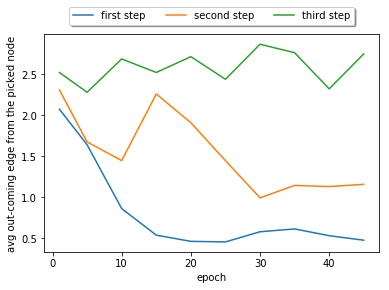

In [42]:
node_1 = [2.075862068965517, 1.6413793103448275, 0.8620689655172413, 0.5379310344827586, 0.46206896551724136, 0.45517241379310347, 0.5793103448275863, 0.6137931034482759, 0.5310344827586206, 0.47586206896551725]
node_2 = [2.310344827586207, 1.6758620689655173, 1.4482758620689655, 2.2620689655172415, 1.910344827586207, 1.4482758620689655, 0.993103448275862, 1.1448275862068966, 1.1310344827586207, 1.1586206896551725]
node_3 = [2.524137931034483, 2.282758620689655, 2.689655172413793, 2.524137931034483, 2.717241379310345, 2.4413793103448276, 2.8689655172413793, 2.7655172413793103, 2.3241379310344827, 2.7517241379310344]
fig, ax = plt.subplots()
x = np.arange(len(node_1))
x = x*5
x[0] += 1
line1 = ax.plot(x, node_1, label="first step")
line2 = ax.plot(x, node_2, label="second step")
line3 = ax.plot(x, node_3, label="third step")
plt.xlabel("epoch")
plt.ylabel("avg out-coming edge from the picked node")
# Shrink current axis by 20%
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 1, box.height])

# Put a legend to the right of the current axis
ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.15),
          fancybox=True, shadow=True, ncol=5)

plt.show()